In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import math

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
#!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
#from plot_image_grid import image_grid
#from generate_cow_renders import generate_cow_renders

In [4]:
#_, cow_images, _ = generate_cow_renders()

In [5]:
from kaigeo import datasets, nerf_models, gan_models

In [6]:
from torchgan.models import DCGANDiscriminator

In [7]:
device = torch.device('cuda')

In [8]:
session2 = datasets.load_session2()
session1 = datasets.load_session1()

In [9]:
#gan_models.generate_cameras(10).T.shape

In [10]:
target_images = torch.concat([session1.target_images, session2.target_images]).to(device)[:, :64, :64][1:]

In [11]:
#target_images = cow_images[:, ::2, ::2].to(device)

In [12]:
print(len(target_images))

504


In [13]:
ls = gan_models.VolumeModel(device).to(device)
opt_ls = torch.optim.Adam(ls.parameters(), lr=0.1)#, weight_decay=1e-5)

/home/brett/miniconda3/envs/geometry/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
d = DCGANDiscriminator(in_size=64, last_nonlinearity=nn.Sigmoid()).to(device) #Discriminator().to(device)
opt_d = torch.optim.Adam(d.parameters(), lr=0.001)

In [15]:
d(target_images[0:1][:, :64, :64].permute(0, 3, 1, 2))

tensor([0.4796], device='cuda:0', grad_fn=<ViewBackward0>)

In [16]:
def descriminator_step():
    opt_d.zero_grad()

    loss = 0
    ri = torch.randint(len(target_images), size=(3,))
    Y = torch.full((3,), 1.0, dtype=torch.float, device=device)            
    y = d(target_images[ri].permute(0, 3, 1, 2))
    loss += torch.nn.functional.binary_cross_entropy(y, Y)
    
    _, rendered = ls.generate(1)
    Y = torch.full((1,), 0.0, dtype=torch.float, device=device)
    y = d(rendered.permute(0, 3, 1, 2))
    loss += torch.nn.functional.binary_cross_entropy(y, Y)

    loss.backward()
    opt_d.step()

    return loss

In [17]:
def generator_step():
    opt_ls.zero_grad()
    density, rendered = ls.generate(10)
    Y = torch.full((10,), 1.0, dtype=torch.float, device=device)
    y  = d(rendered.permute(0, 3, 1, 2))
    mean_density = torch.mean(density)
    loss = torch.nn.functional.binary_cross_entropy(y, Y) #- 3.0*mean_density

    loss.backward()    
    opt_ls.step()

    return loss, mean_density, rendered

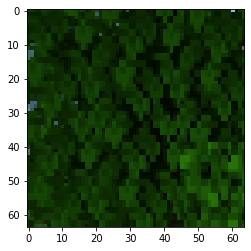

In [18]:
plt.imshow(target_images[22].detach().cpu().numpy())

In [36]:
for i in range(300):
    d_loss = descriminator_step()    
    for _ in range(2):
        g_loss, mean_density, rendered = generator_step()
    
    if i % 50 == 0:
        print('d', d_loss)
        print('ls', g_loss)
        print('density', mean_density)


d tensor(2.2754, device='cuda:0', grad_fn=<AddBackward0>)
ls tensor(1.0142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
density tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
d tensor(0.0305, device='cuda:0', grad_fn=<AddBackward0>)
ls tensor(2.0912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
density tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
d tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)
ls tensor(0.5464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
density tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
d tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
ls tensor(1.6827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
density tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
d tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
ls tensor(1.0582, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
density tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)


KeyboardInterrupt: 

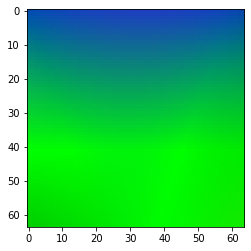

In [37]:
plt.imshow(rendered.detach().cpu()[8])

In [ ]:
plt.imshow(target_images.detach().cpu()[200])

In [ ]:
plt.imshow(generate_images()[1].detach().cpu()[0])

In [ ]:
torch.min(generate_images()[1].detach().cpu()[0])t

In [ ]:
R, T = look_at_view_transform(
    eye = torch.tensor([[0.9, s0.0, 0.0]]), 
    at = torch.tensor([[0.0, 0.0, 0.0]])
)

target_cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

rendered, _ = renderer_grid(target_cameras, ls.random_gen)
rendered = rendered[:, :, :, 1:4]
Y = torch.full((1,), 1.0, dtype=torch.float, device=device)
y = d(rendered.permute(0, 3, 1, 2)).view(-1)
plt.imshow(rendered.detach().cpu()[0])

In [ ]:
opt.zero_grad()
res, _ = renderer_grid(target_cameras, volumetric_function)
loss = torch.nn.functional.mse_loss(res[0][:, :, 1:4], target_image)
loss.backward()
opt.step()